In [16]:
import deeptrack as dt
from deeptrack.models.yolo import utils
import numpy as np
import matplotlib.pyplot as plt

from simulation import *

In [17]:
sim= MultiParticle(
    
    
    n_particles = lambda: int(np.random.rand()*10) + 15,
        
    
)
starting_value = dt.Value(lambda: np.ones((IMAGE_SIZE, IMAGE_SIZE)))

sim= starting_value >> MultiParticle(
    n_particles = lambda: int(np.random.rand()*10) + 15,
)

particle =  sim[0]
pos =  sim[1]
rad =  sim[2]






In [18]:
print(np.shape(particle.resolve()))

Image((1, 100, 100))


In [19]:
gradient = dt.IlluminationGradient(
    gradient=[.5e-3, 0e-3],#lambda: 1e-3 + np.random.randn(2) * 1e-3,
)

class Normalize(dt.Feature):
    def __init__(
        self, **kwargs
    ):
        super().__init__( **kwargs)

    def get(self, image, **kwargs):
        image = image / np.max(image)
        return image

normalization = Normalize()

gauss = dt.Gaussian(mu = 0, sigma = .01)

import scipy
#Smoothing
kernel = np.ones((3, 3)) / 15
smoothing = dt.Lambda(lambda: lambda image: scipy.ndimage.filters.convolve(image, kernel)) 

particle = particle  >> gauss >> normalization 

In [22]:
"""def get_label(a, b):
    a = a.resolve()
    b = b.resolve()
    n = int(np.shape(a)[0])
    label = np.zeros((n,4))

    for i in range(n):
        label[i,:] = [int(a[i, 0]), int(a[i, 1]), b[i], b[i]]

    
    return label #(np.asarray(a.resolve()), np.asarray(b.resolve()))"""

def get_label(rad, pos):
    rad = np.array(rad)
    pos = np.array(pos)
        
    n = np.shape(rad)[0]  
    label = np.zeros((n, 5))

    for i in range ( n ):
        label[i, : ] = [int(pos[i, 0]), int(pos[i, 1]), rad[i,0], rad[i,0], 0]
    
    #print(label)
    return label

In [23]:


label_func = particle >> dt.Lambda(lambda rad, pos: lambda x: get_label(rad, pos), rad=rad, pos=pos)
#bboxes.resolve()
#data = particle & bboxes
#print(data.resolve())


print(label_func.resolve())

Image(array([[37.        ,  3.        ,  2.60565796,  2.60565796,  0.        ],
       [ 8.        , 31.        ,  2.20776951,  2.20776951,  0.        ],
       [34.        , 84.        ,  2.41219806,  2.41219806,  0.        ],
       [40.        , 25.        ,  2.32655306,  2.32655306,  0.        ],
       [70.        ,  2.        ,  2.82033095,  2.82033095,  0.        ],
       [59.        , 84.        ,  2.94058762,  2.94058762,  0.        ],
       [16.        , 63.        ,  2.31943087,  2.31943087,  0.        ],
       [65.        , 48.        ,  2.14485363,  2.14485363,  0.        ],
       [93.        , 93.        ,  2.86121201,  2.86121201,  0.        ],
       [52.        , 29.        ,  2.97023108,  2.97023108,  0.        ],
       [62.        , 40.        ,  2.2133265 ,  2.2133265 ,  0.        ],
       [11.        , 53.        ,  2.98251629,  2.98251629,  0.        ],
       [35.        , 62.        ,  2.85615899,  2.85615899,  0.        ],
       [24.        ,  5.        

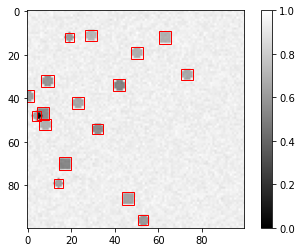

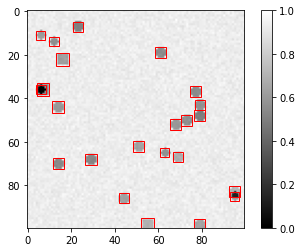

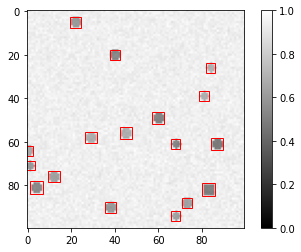

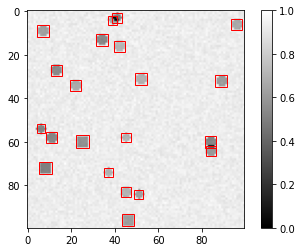

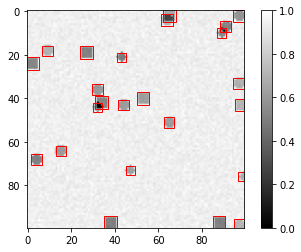

In [24]:
NUMBER_OF_IMAGES = 5

for _ in range(NUMBER_OF_IMAGES):
    particle.update()
    pos = pos.update()
    rad = rad.update()
    
    bboxes = label_func.resolve()

    
    #print(np.array(bboxes))
    image_of_particle = particle.resolve()
    

    
    n = np.shape(bboxes)[0]
    position_of_particles = bboxes[:,0:2]
    #print(position_of_particles)
    radius_of_particles = bboxes[:,2] 
    
    plt.imshow(image_of_particle.reshape((IMAGE_SIZE, IMAGE_SIZE)), cmap="gray", vmin = 0)
    plt.colorbar()
    ax = plt.gca()
    for i in range(int(n)):
        rect = plt.Rectangle((position_of_particles[i,0]-radius_of_particles[i],position_of_particles[i,1]-radius_of_particles[i]),2*radius_of_particles[i],2*radius_of_particles[i],linewidth=1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
    
    
    #plt.scatter(position_of_particles[:,0], position_of_particles[:,1], marker='+', edgecolors="r", linewidth=2)
    plt.show()

In [25]:
from deeptrack.models.yolo.yolo import YOLOv3

model = YOLOv3(
    (100, 100, 1),
    1,
)

model.compile(optimizer="adam")

In [26]:
from deeptrack.models.yolo.dataset import YoloDataGenerator

data = particle & bboxes

generator = YoloDataGenerator(
    feature=data,
    input_size=np.array([100]),
    num_class=1,
    label_function=lambda d: np.array(d[1:]),
    batch_size=4,
    min_data_size=100,
    max_data_size=200,
)

generator.anchors = model.anchors

In [27]:
with generator:
    model.fit(generator, epochs=50)

Generating 112 / 100 samples before starting training


IndexError: arrays used as indices must be of integer (or boolean) type